## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'syntheticMRI3D-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'dad'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
dad_wavelet_full_syntheticMRI3D.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/syntheticMRI3D/full/wavelet/dad'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 0, 3: 564, 4: 22538, 5: 296776, 6: 2880648, 7: 25362406, 8: 213093688}

Running 12760 CDFs


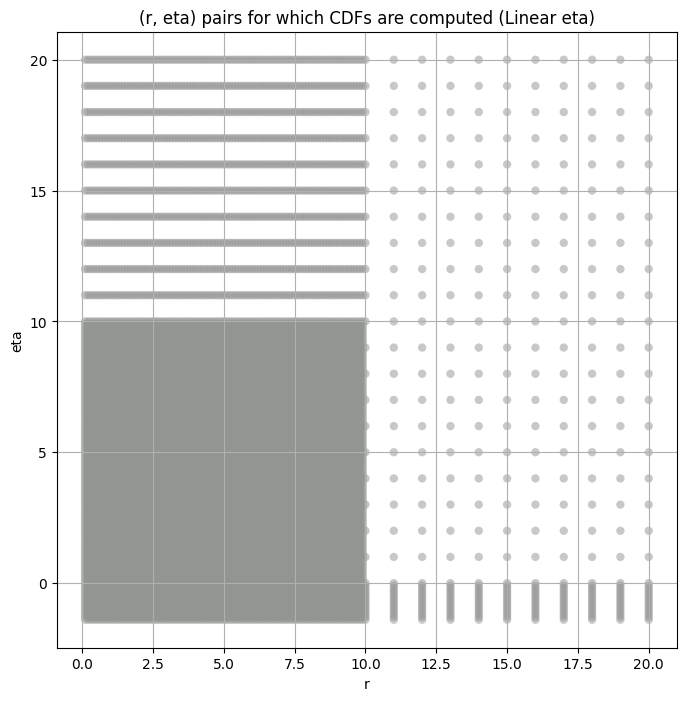

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2               NaN            NaN           NaN         NaN         NaN   
3      1.177849e+06  996756.250000  1.369790e+06    0.133331   -0.296798   
4      5.544239e+05  530262.940000  5.787912e+05    0.887641    0.729112   
5      8.563575e+04   80896.880000  9.057298e+04    2.790587    2.209590   
6      1.720976e+04   15558.705000  1.896846e+04   12.881204   10.923777   
7      1.438634e+03    1291.273300  1.598209e+03   15.234228   12.320395   
8      5.583345e+01      46.389084  8.071121e+01  133.449080   13.199213   

       kurt_upper  total_samples  
layer                             
2             NaN            0.0  
3        0.629724          564.0  
4        1.060642        22538.0  
5        3.619065       296776.0  
6       14.954548      2880648.0  
7       18.880985     25362406.0  
8      557.197800    213093688.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2               NaN            NaN             NaN             NaN   
3      1.177849e+06   1.177849e+06   745420.812500   524011.062500   
4      5.544239e+05   5.544239e+05   539800.000000   529119.562500   
5      8.563575e+04   8.563575e+04    84283.039062    83240.531250   
6      1.720976e+04   1.720976e+04    16655.187500    16200.065430   
7      1.438634e+03   1.438635e+03     1380.506592     1337.607666   
8      5.583345e+01   5.583345e+01       48.501541       46.593613   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3       378267.531250    265051.281250    119650.320312     39274.914062   
4       519332.125000    510220.093750    493554.500000    478187.000000   
5        82315.867188     81476.062500     79984.835938     78658.046875   
6        15792.823242     15422.764648     14763.700195     14191.649414   
7         1300.776733      1267.950317      1210.658081      1161.310303   
8           45.177536        43.989357        42.014721        40.378292   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3          3046.893555              NaN              NaN              NaN  
4        463749.531250    450230.750000    437562.156250    403202.875000  
5         77452.554688     76338.304688     75306.742188     72569.406250  
6         13686.343750     13233.665039     12822.242188     11770.579102  
7          1117.798096      1078.906128      1043.727295       954.744507  
8            38.966904        37.719585        36.598450        33.777023

####
Layer  2
####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.01803864674062461 1177849.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.060189795037231625 745420.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.09759915990564377 524011.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.1331781445484727 378267.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.16600401688104252 265051.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.24478987125424578 119650.32


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.3158752161787606 39274.914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.415690436635883 3046.8936


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 nan nan
Number of samples: 564, Without approximation : 564.0


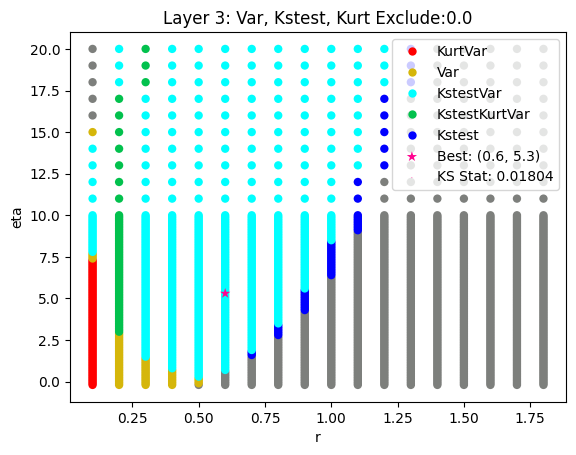

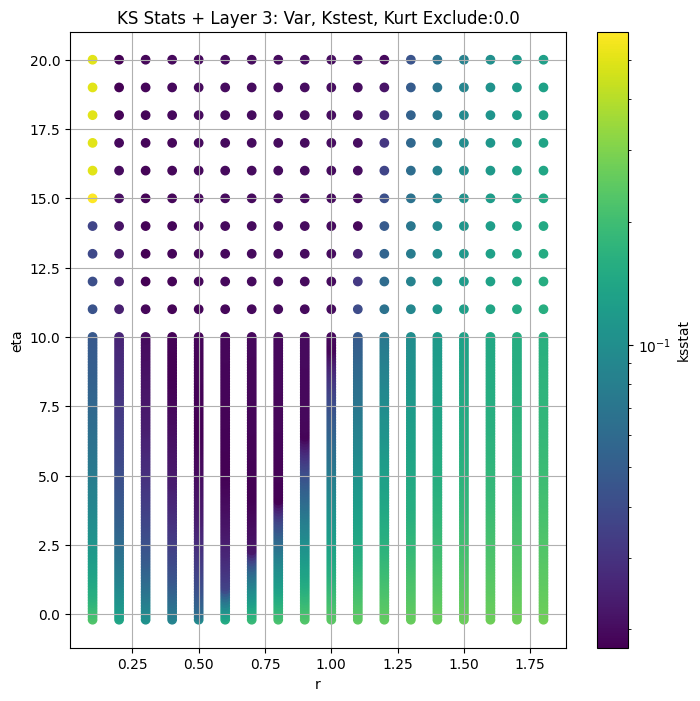

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.030387944574517906 554423.94


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.031073152575946367 539800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.03257280103047622 529119.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.032696738821772264 519332.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.03271075444912308 510220.1


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.034232124128119046 493554.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.0357865170981948 478187.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.03650193020111027 463749.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.038237706757505985 450230.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.038947391382433486 437562.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.04273887770595569 403202.88
Number of samples: 22538, Without approximation : 22538.0


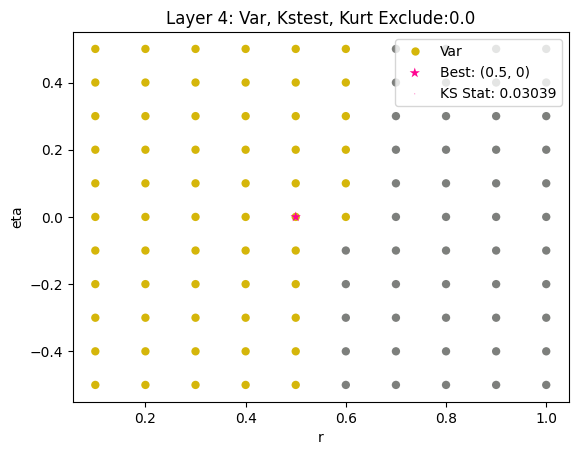

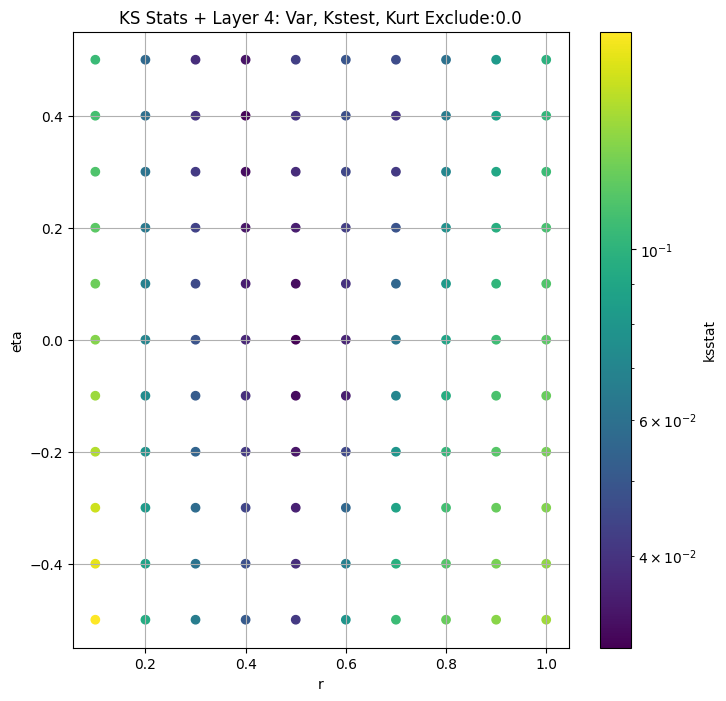

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0025109854931805176 85635.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.0020952071712836418 84283.04


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.00284928128739724 83240.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0026684656315861255 82315.87


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.003163091469106122 81476.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0035240988907429827 79984.836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.004145237077019748 78658.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.005104340196070867 77452.555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.005860376348589269 76338.305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.006590845771602072 75306.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.008783892295679455 72569.41
Number of samples: 100000, Without approximation : 296776.0


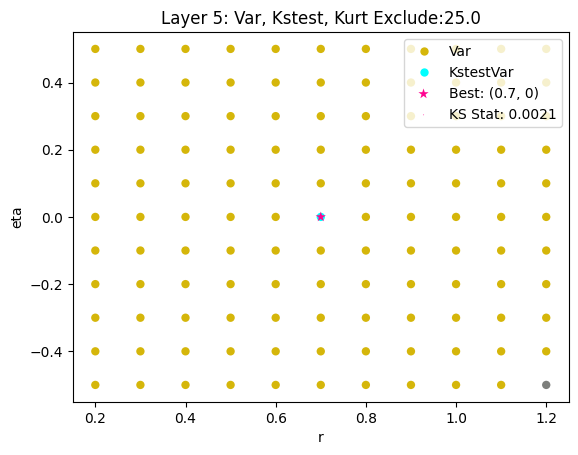

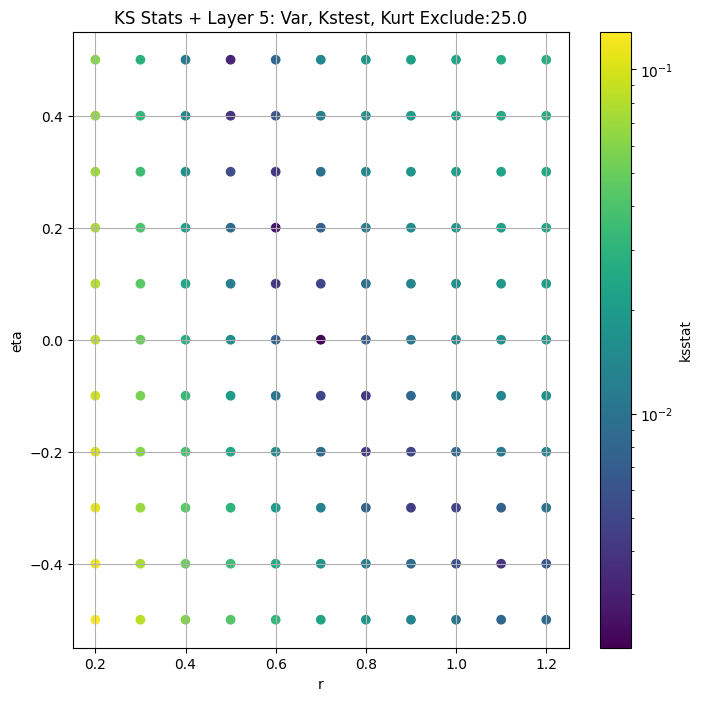

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.010283859160581832 17209.758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.009307737870207888 16655.188


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.008686842965961006 16200.065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.008130314534913308 15792.823


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.007554359493589402 15422.765


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.006457776826735873 14763.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0055917038369962535 14191.649


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.005502934670567616 13686.344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006010213567954947 13233.665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.0064184982958764465 12822.242


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.00786873365612761 11770.579
Number of samples: 100000, Without approximation : 2880648.0


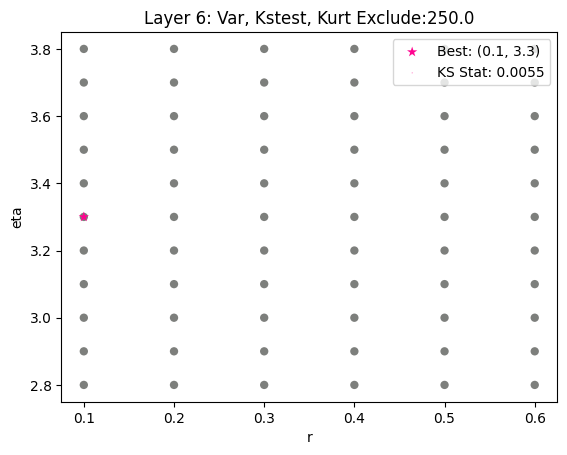

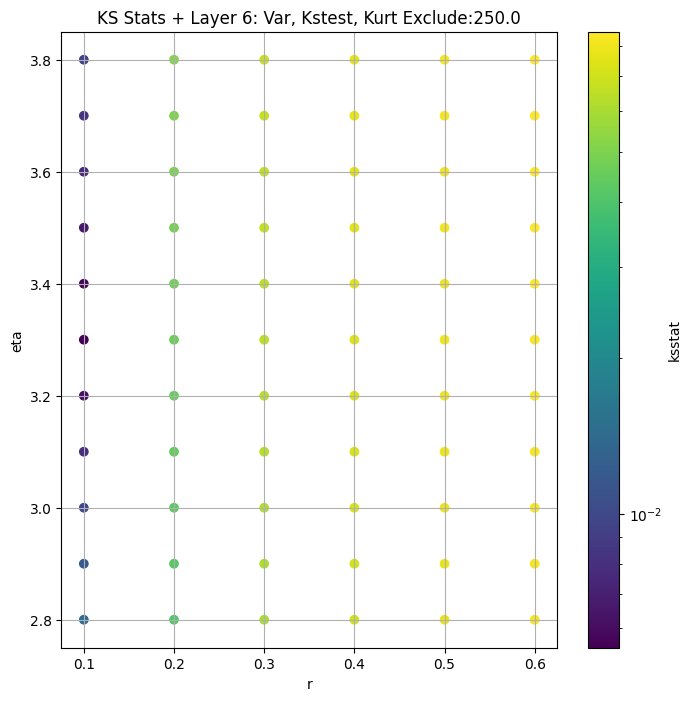

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.005975815193940859 1438.6345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.005142168618703313 1380.5066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.0038373611554877174 1337.6077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.003643622378078623 1300.7767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.003856168512555576 1267.9503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0046576991270945445 1210.6581


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.0048708782341817525 1161.3103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.0055720265777211946 1117.7981


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.005934237684513288 1078.9061


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.006334196571060843 1043.7273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.00804781352647025 954.7445
Number of samples: 100000, Without approximation : 25362406.0


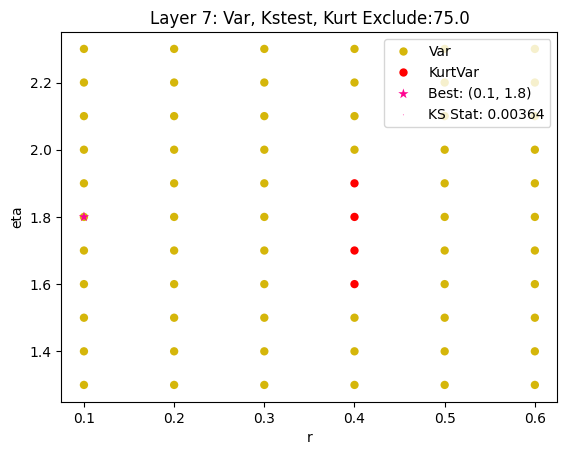

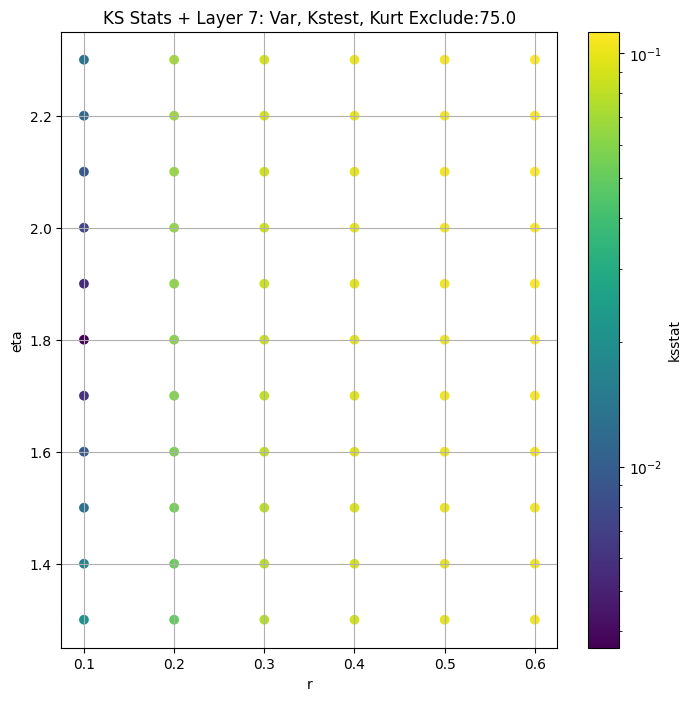

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0035795228710652216 55.83345


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.0026044400844745796 48.50154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.003518587372563352 46.593613


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.0034001636558633197 45.177536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.003668394201042924 43.989357


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.004373461559038949 42.01472


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.004888292393823268 40.378292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.005698208715441244 38.966904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.005993450479519158 37.719585


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.006802413862000978 36.59845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008292494101430195 33.777023
Number of samples: 100000, Without approximation : 213093688.0


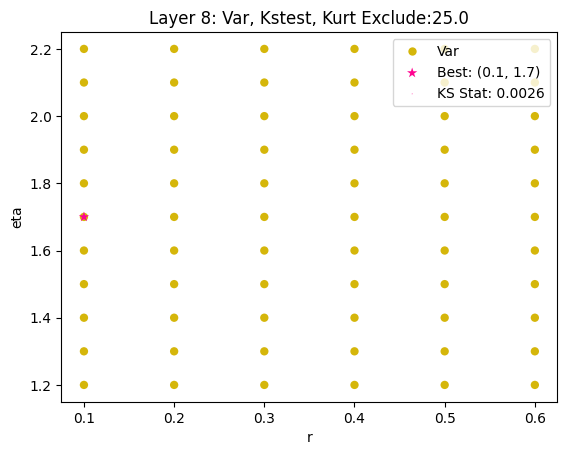

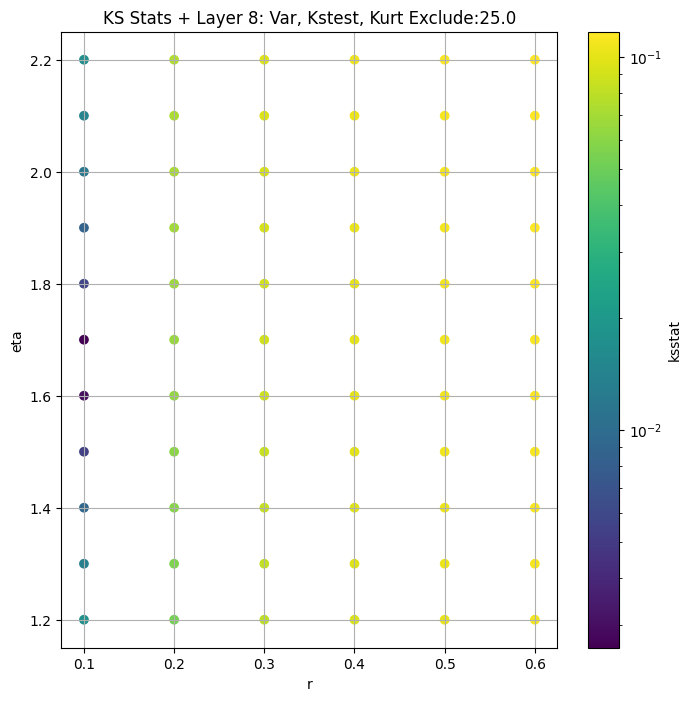

obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2               NaN            NaN           NaN         NaN         NaN   
3      1.177849e+06  996756.250000  1.369790e+06    0.133331   -0.296798   
4      5.544239e+05  530262.940000  5.787912e+05    0.887641    0.729112   
5      8.563575e+04   80896.880000  9.057298e+04    2.790587    2.209590   
6      1.720976e+04   15558.705000  1.896846e+04   12.881204   10.923777   
7      1.438634e+03    1291.273300  1.598209e+03   15.234228   12.320395   
8      5.583345e+01      46.389084  8.071121e+01  133.449080   13.199213   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            0.0                  NaN        NaN          NaN   
3        0.629724          564.0             0.018039        0.6          5.3   
4        1.060642        22538.0             0.030388        0.5          0.0   
5        3.619065       296776.0             0.002095        0.7          0.0   
6       14.954548      2880648.0             0.005503        0.1          3.3   
7       18.880985     25362406.0             0.003644        0.1          1.8   
8      557.197800    213093688.0             0.002604        0.1          1.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2                NaN                     NaN                 NaN   
3       1.964442e+04                     0.0        1.177849e+06   
4       4.620199e+04                     0.0        5.544239e+05   
5       2.503724e+04                    25.0        8.428304e+04   
6       8.733964e-14                   250.0        1.368634e+04   
7       2.436107e-13                    75.0        1.300777e+03   
8       1.192198e-14                    25.0        4.850154e+01   

       kstest_stat_cutoff_0.05  
layer                           
2                          NaN  
3                     0.056882  
4                     0.009039  
5                     0.002492  
6                     0.000800  
7                     0.000270  
8                     0.000093

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2
Layer 3


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.16820064880156219, var: 265051.28125


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.13536539636205597, var: 378267.53125


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.1014886683573053, var: 524011.0625


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.06265870509527081, var: 745420.8125


  0%|          | 0/891 [00:00<?, ?it/s]

Finding Minimum after computing 891 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.018036958735420328, var: 1177849.375
Number of samples: 564, Without approximation : 564.0


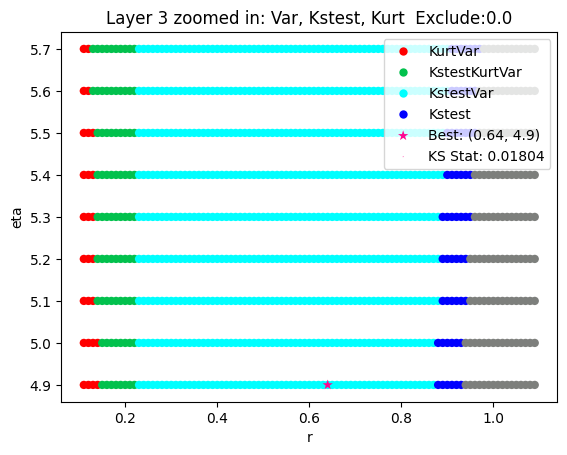

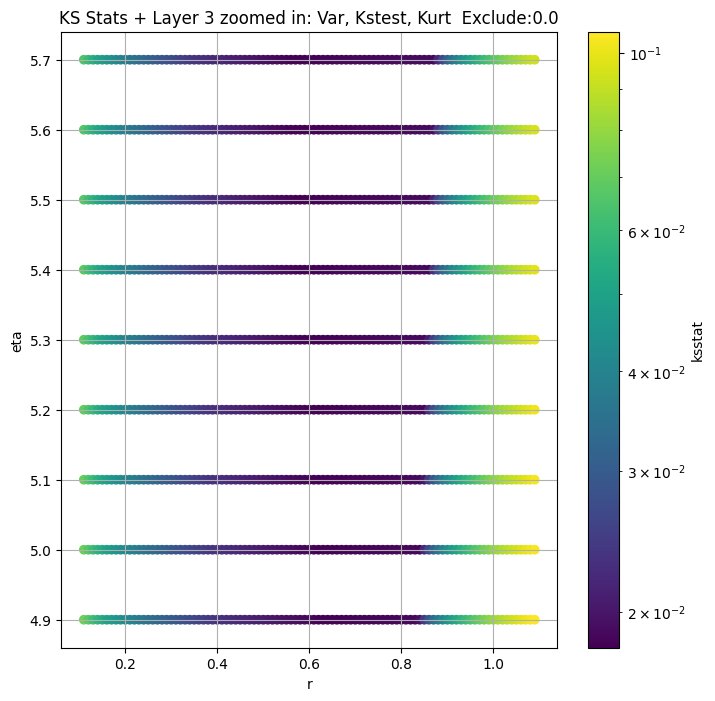

Layer 4


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.032343432995613985, var: 510220.09375


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.031709909798140035, var: 519332.125


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.03130380745550346, var: 529119.5625


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.030302552604467792, var: 539800.0


  0%|          | 0/1287 [00:00<?, ?it/s]

Finding Minimum after computing 1287 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.0294684846300457, var: 554423.9375
Number of samples: 22538, Without approximation : 22538.0


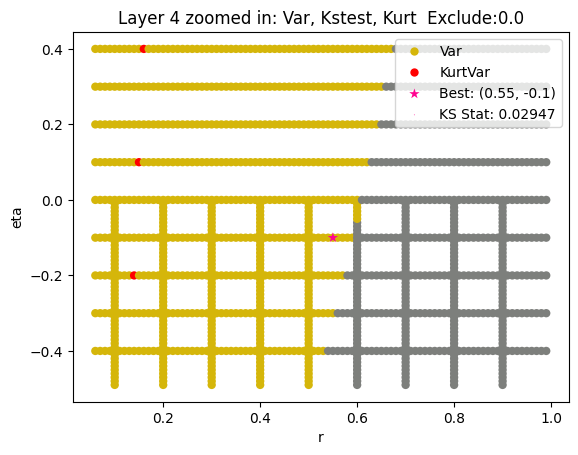

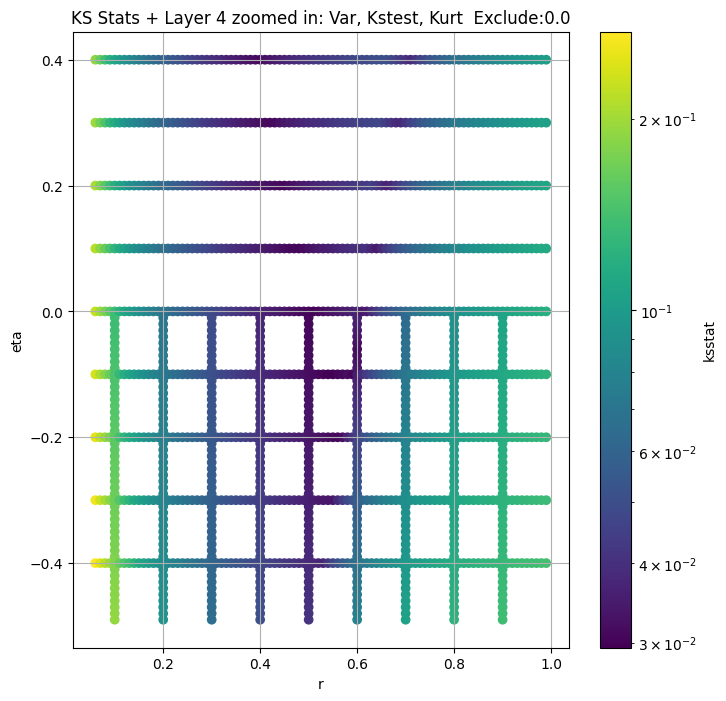

Layer 5


  0%|          | 0/1350 [00:00<?, ?it/s]

Finding Minimum after computing 1350 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.003007846689828786, var: 80704.125


  0%|          | 0/1350 [00:00<?, ?it/s]

Finding Minimum after computing 1350 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.002729213633241634, var: 81476.0625


  0%|          | 0/1350 [00:00<?, ?it/s]

Finding Minimum after computing 1350 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.0025657857231219383, var: 82315.8671875


  0%|          | 0/1350 [00:00<?, ?it/s]

Finding Minimum after computing 1350 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.002324139897934119, var: 83240.53125


  0%|          | 0/1350 [00:00<?, ?it/s]

Finding Minimum after computing 1350 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.0020952071712836418, var: 84283.0390625


  0%|          | 0/1350 [00:00<?, ?it/s]

Finding Minimum after computing 1350 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.0019331798646739645, var: 85635.75
Number of samples: 100000, Without approximation : 296776.0


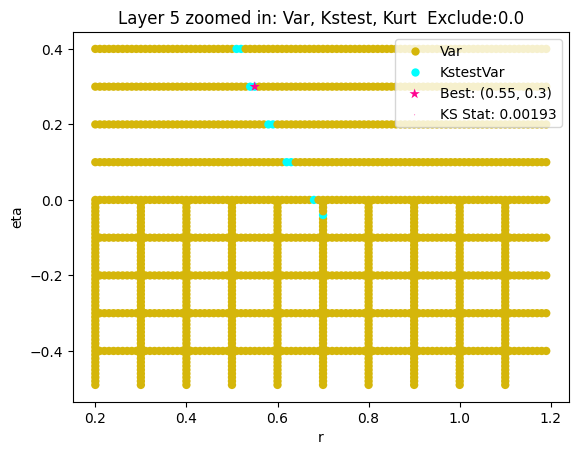

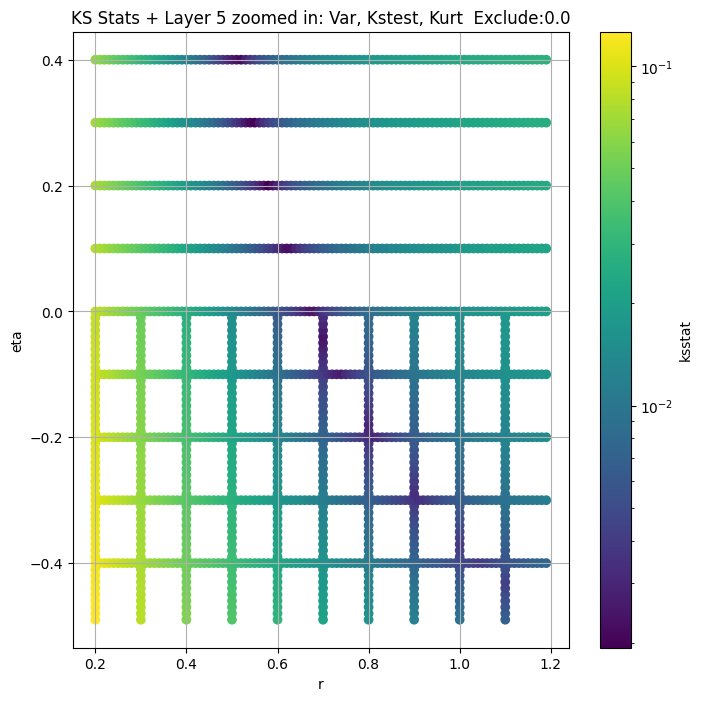

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.006529229929048735, var: 12822.2421875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.006278678373011909, var: 13023.2626953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.005997428632105728, var: 13233.6650390625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.005749843771403196, var: 13454.4091796875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.005502934670567616, var: 13686.34375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.005206041938636274, var: 13931.5830078125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.0055917038369962535, var: 14191.6494140625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.0060142214825803925, var: 14468.0654296875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.006457776826735873, var: 14763.7001953125
Number of samples: 100000, Without approximation : 2880648.0


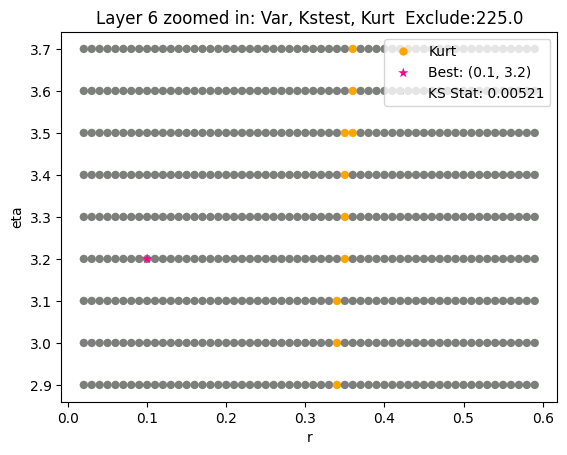

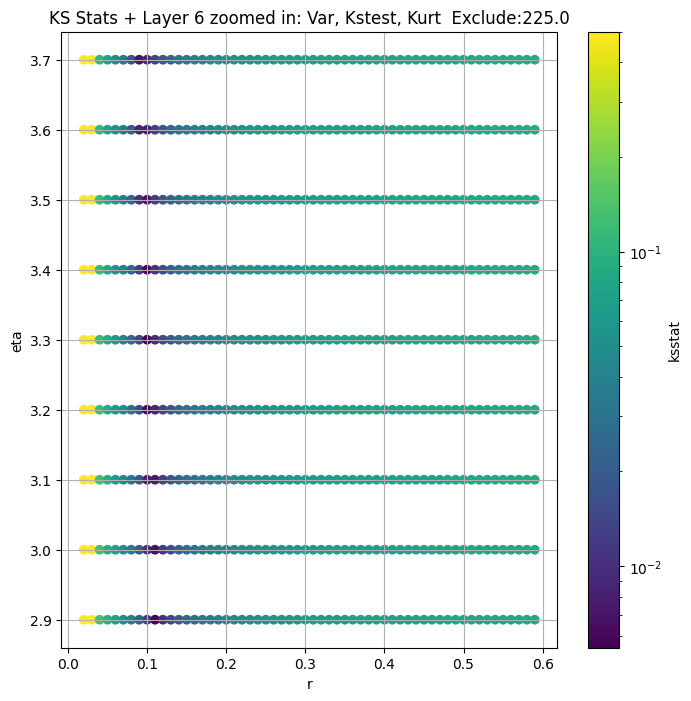

Layer 7


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + 100 = 175, ksstat: 0.004893361900021213, var: 1185.1513671875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + 75 = 150, ksstat: 0.0045258549048844375, var: 1210.6580810546875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + 50 = 125, ksstat: 0.00420366341770299, var: 1238.10693359375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + 25 = 100, ksstat: 0.0038171241552438662, var: 1267.9503173828125


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + 0 = 75, ksstat: 0.0035123422232911095, var: 1300.7767333984375


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + -25 = 50, ksstat: 0.0036500138484662076, var: 1337.607666015625


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + -50 = 25, ksstat: 0.004105201420960769, var: 1380.506591796875


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 7, 75.0 + -75 = 0, ksstat: 0.00503532916430513, var: 1438.634521484375
Number of samples: 100000, Without approximation : 25362406.0


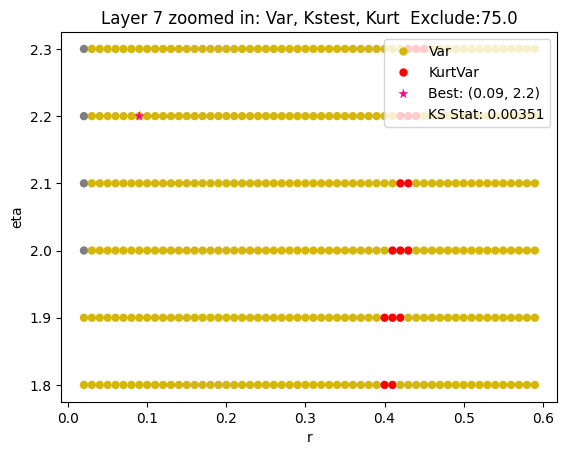

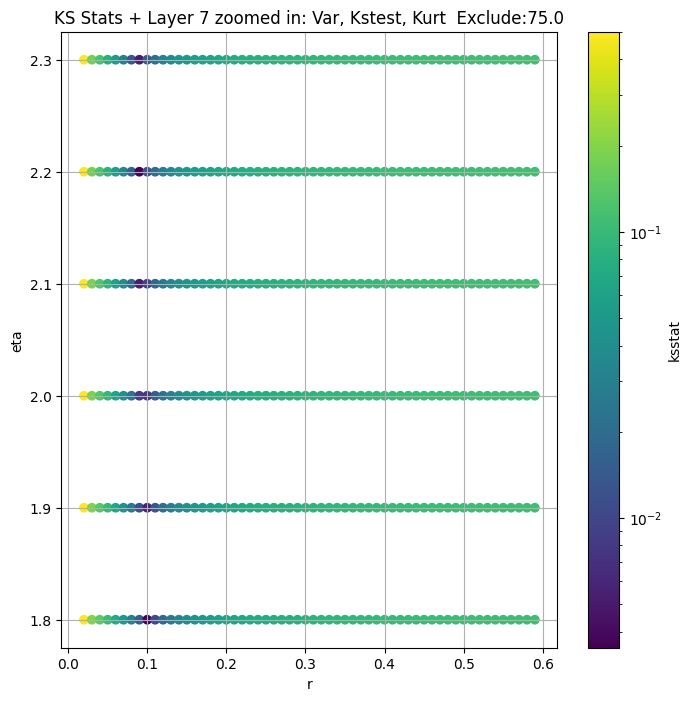

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.005154069997112945, var: 42.94853210449219


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.004710464824163596, var: 43.989356994628906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.004081412508810667, var: 45.17753601074219


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.003518587372563352, var: 46.59361267089844


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.0026044400844745796, var: 48.50154113769531


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.0019315750902819673, var: 55.83345031738281
Number of samples: 100000, Without approximation : 213093688.0


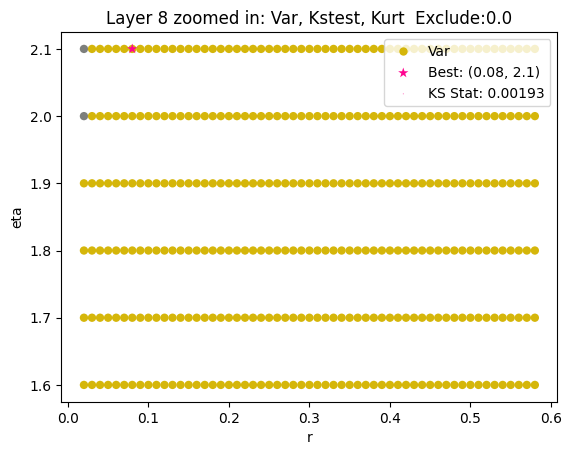

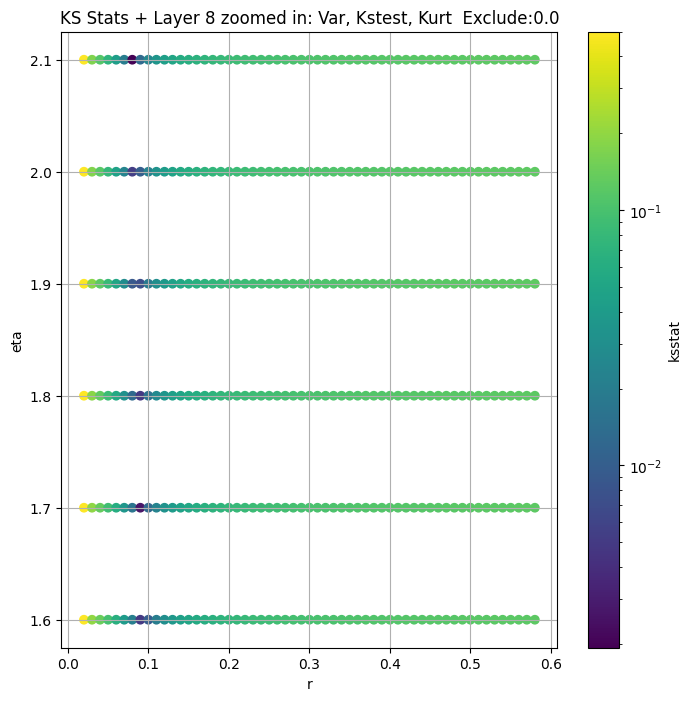

Cannot compute pval with ksstat : nan, n : 0.0


obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2               NaN            NaN           NaN         NaN         NaN   
3      1.177849e+06  996756.250000  1.369790e+06    0.133331   -0.296798   
4      5.544239e+05  530262.940000  5.787912e+05    0.887641    0.729112   
5      8.563575e+04   80896.880000  9.057298e+04    2.790587    2.209590   
6      1.720976e+04   15558.705000  1.896846e+04   12.881204   10.923777   
7      1.438634e+03    1291.273300  1.598209e+03   15.234228   12.320395   
8      5.583345e+01      46.389084  8.071121e+01  133.449080   13.199213   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            0.0                  NaN        NaN          NaN   
3        0.629724          564.0             0.018039        0.6          5.3   
4        1.060642        22538.0             0.030388        0.5          0.0   
5        3.619065       296776.0             0.002095        0.7          0.0   
6       14.954548      2880648.0             0.005503        0.1          3.3   
7       18.880985     25362406.0             0.003644        0.1          1.8   
8      557.197800    213093688.0             0.002604        0.1          1.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2                NaN                     NaN                 NaN   
3       1.964442e+04                     0.0        1.177849e+06   
4       4.620199e+04                     0.0        5.544239e+05   
5       2.503724e+04                    25.0        8.563575e+04   
6       8.733964e-14                   250.0        1.393158e+04   
7       2.436107e-13                    75.0        1.300777e+03   
8       1.192198e-14                    25.0        5.583345e+01   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                          NaN               NaN     NaN       NaN   
3                     0.056882          0.018037    0.64       4.9   
4                     0.009039          0.029468    0.55      -0.1   
5                     0.002492          0.001933    0.55       0.3   
6                     0.000800          0.005206    0.10       3.2   
7                     0.000270          0.003512    0.09       2.2   
8                     0.000093          0.001932    0.08       2.1   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2               NaN                  NaN           -1  
3      3.091389e+04                  0.0         5416  
4      7.891671e+04                  0.0         2112  
5      8.111061e+03                  0.0       500809  
6      1.078205e-13                225.0        67515  
7      4.297988e-16                 75.0       148606  
8      2.771022e-20                  0.0       499996

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

> In quadgk/vadapt (line 278)
In quadgk (line 204)
In compute_cdf_using_gengamma_with_scale (line 10)


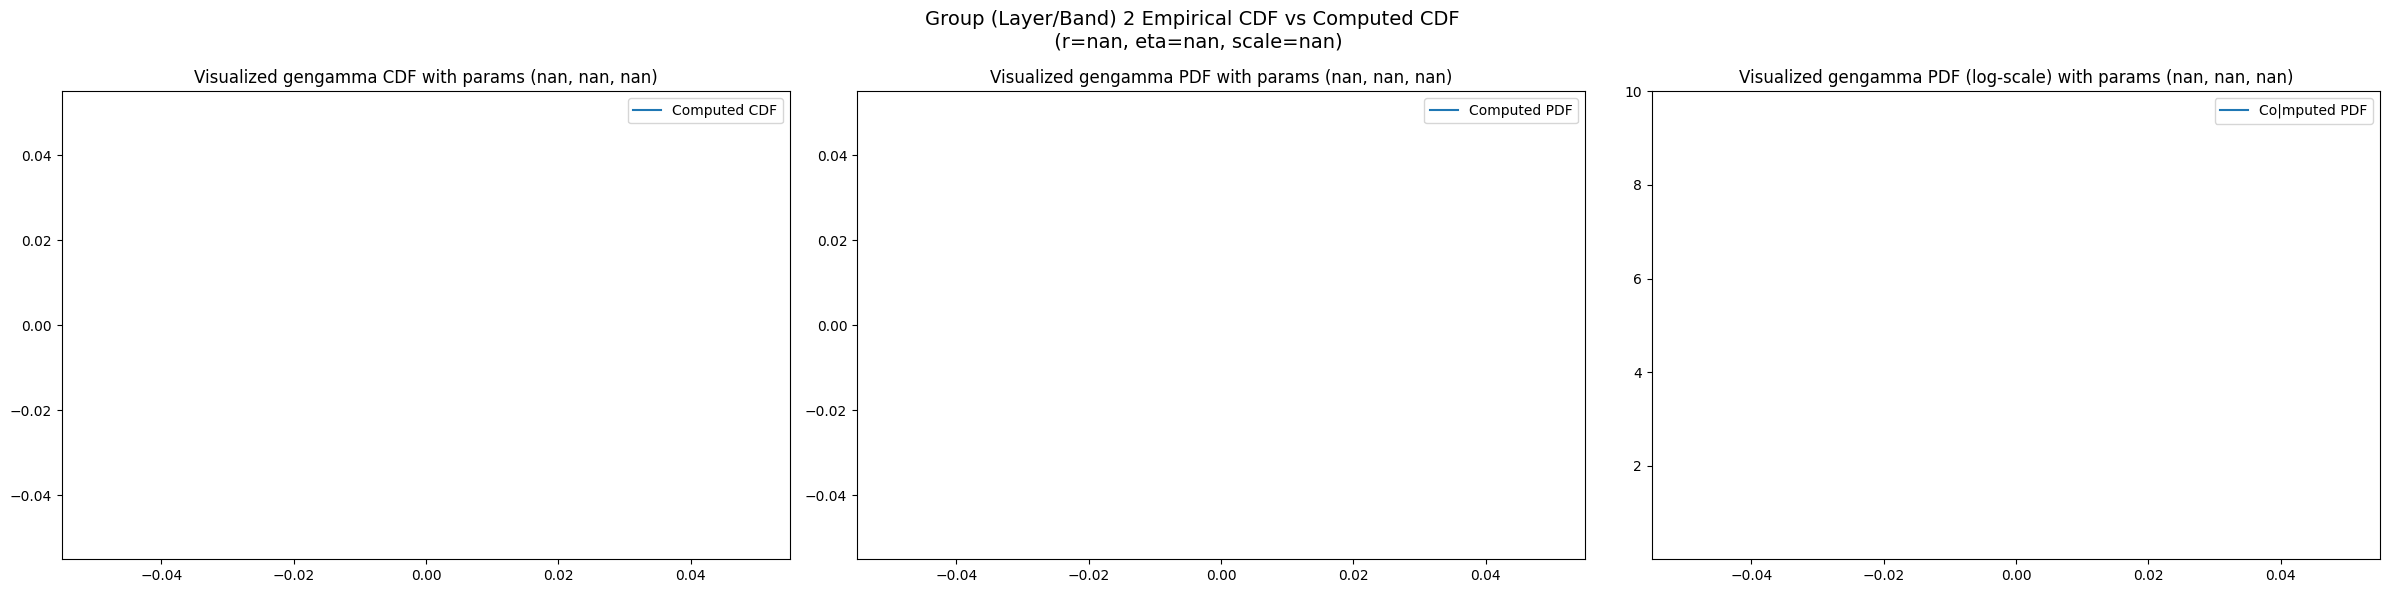

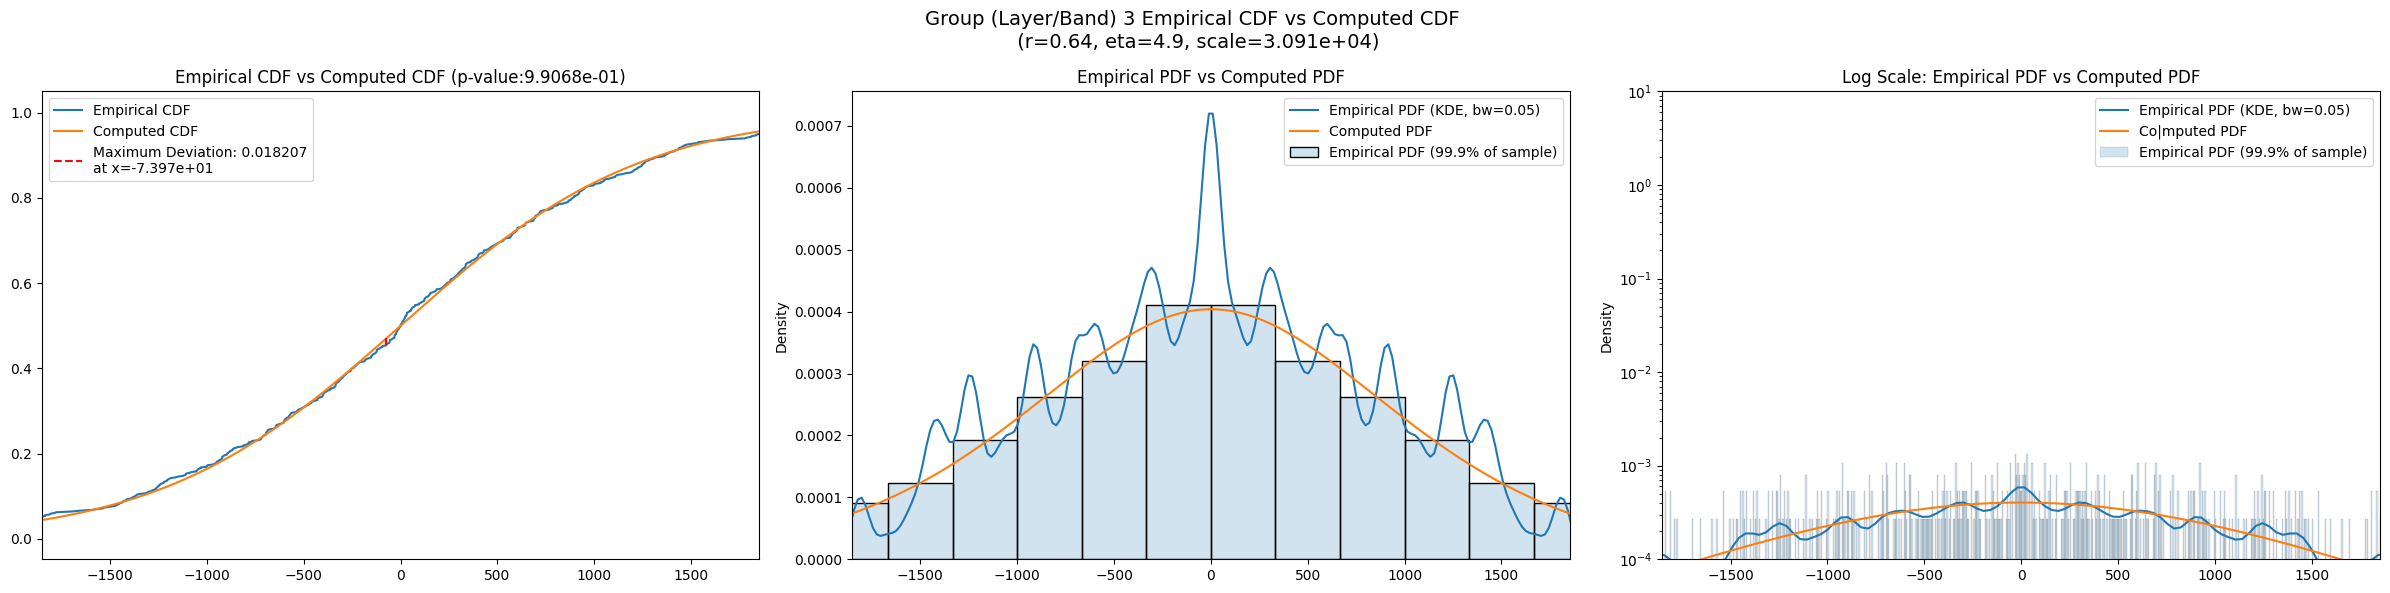

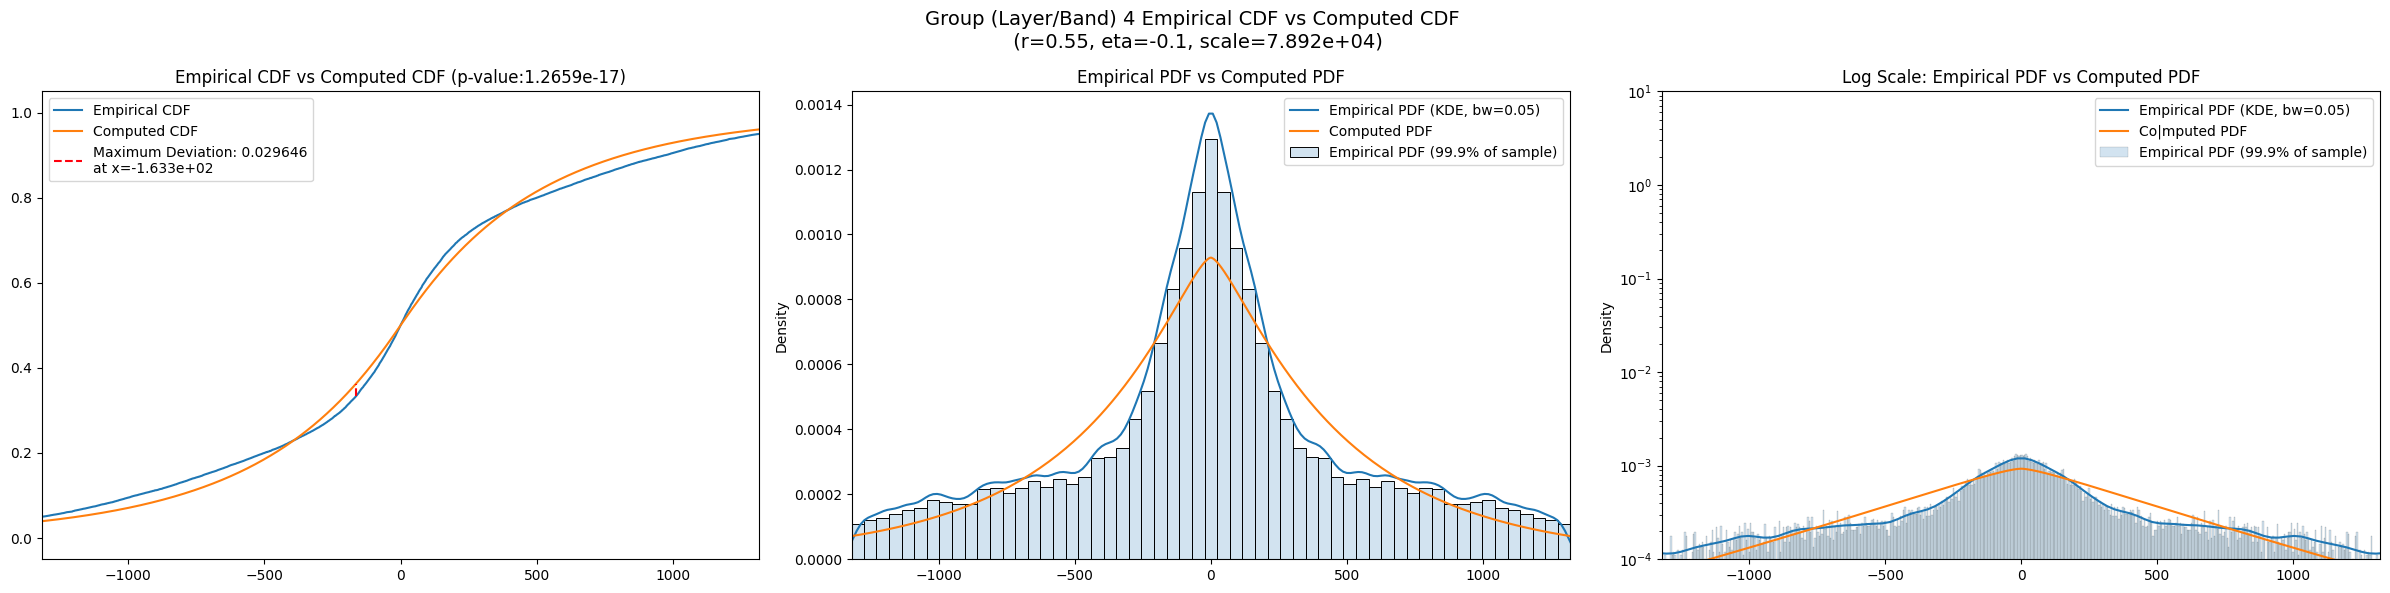

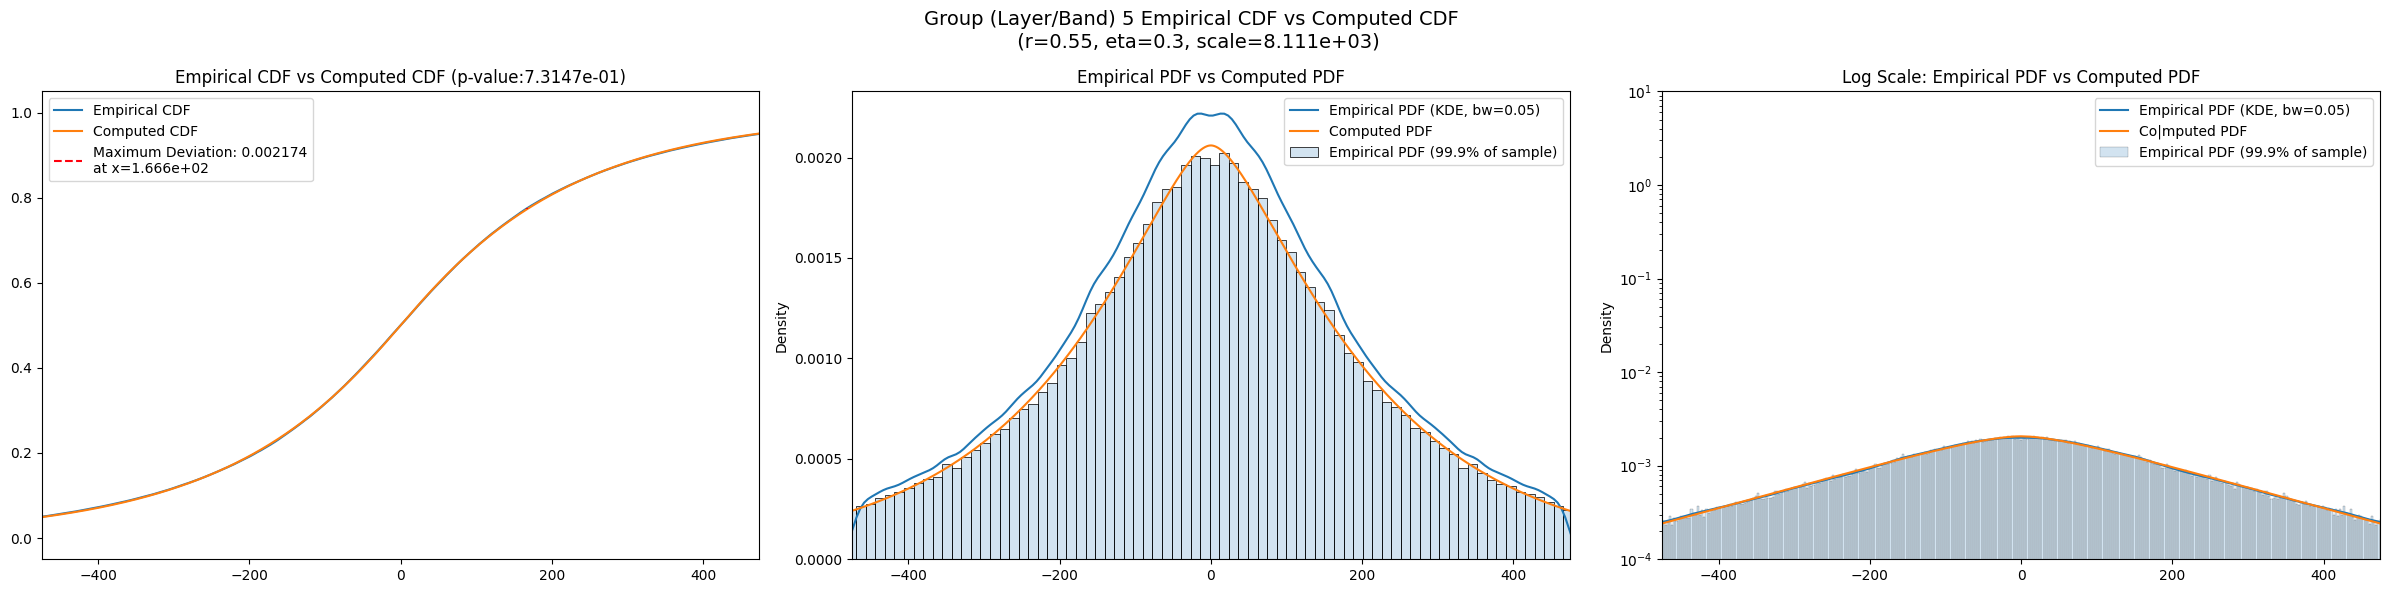

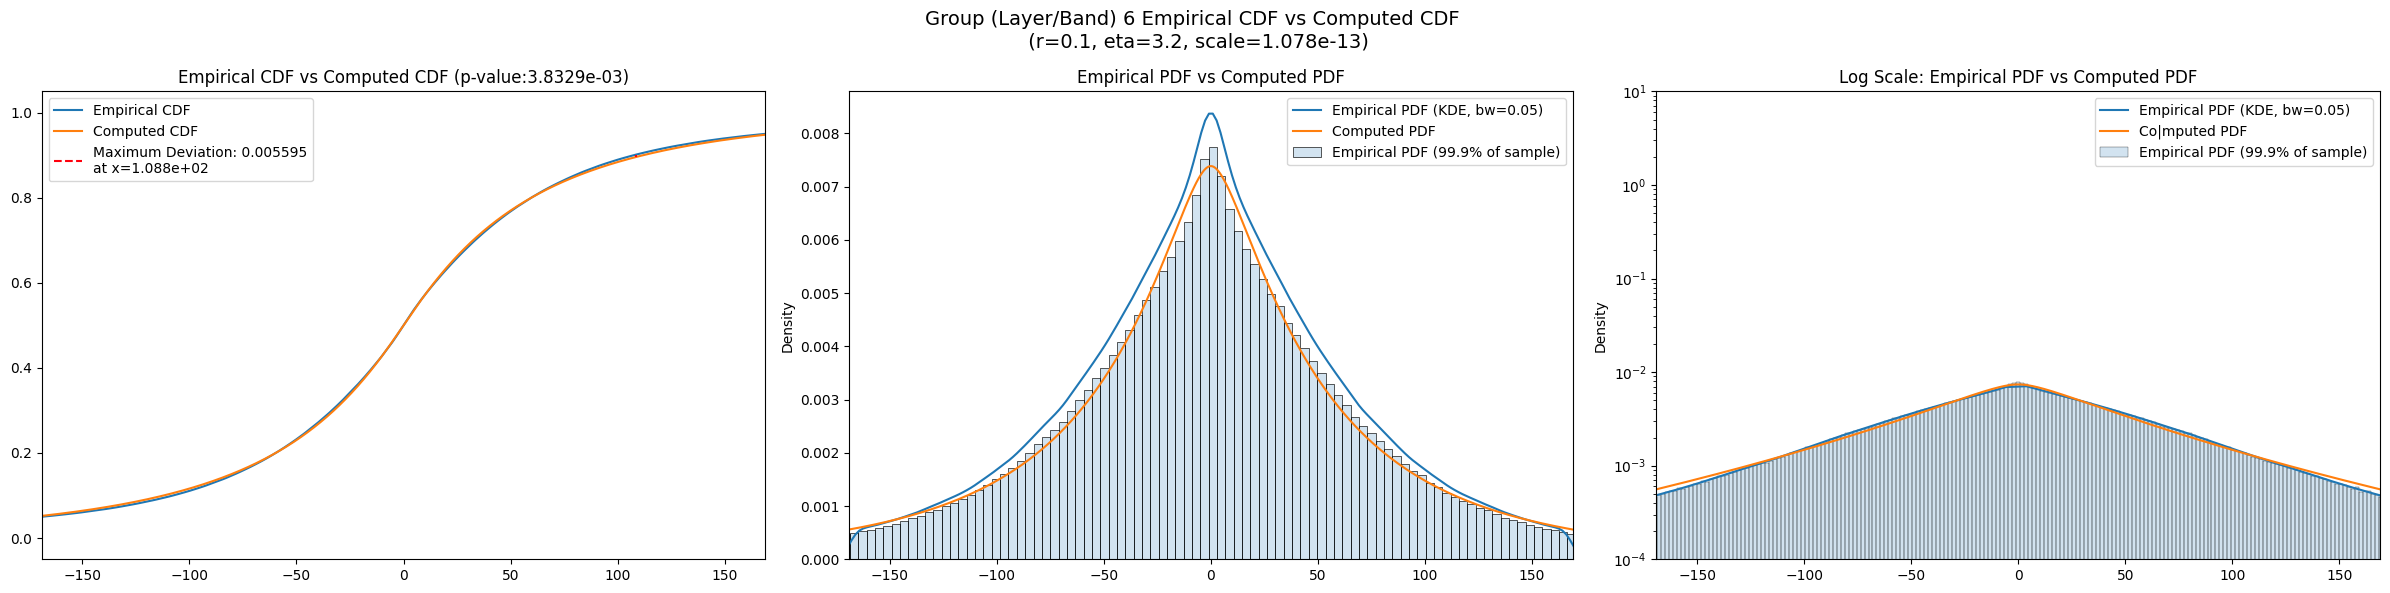

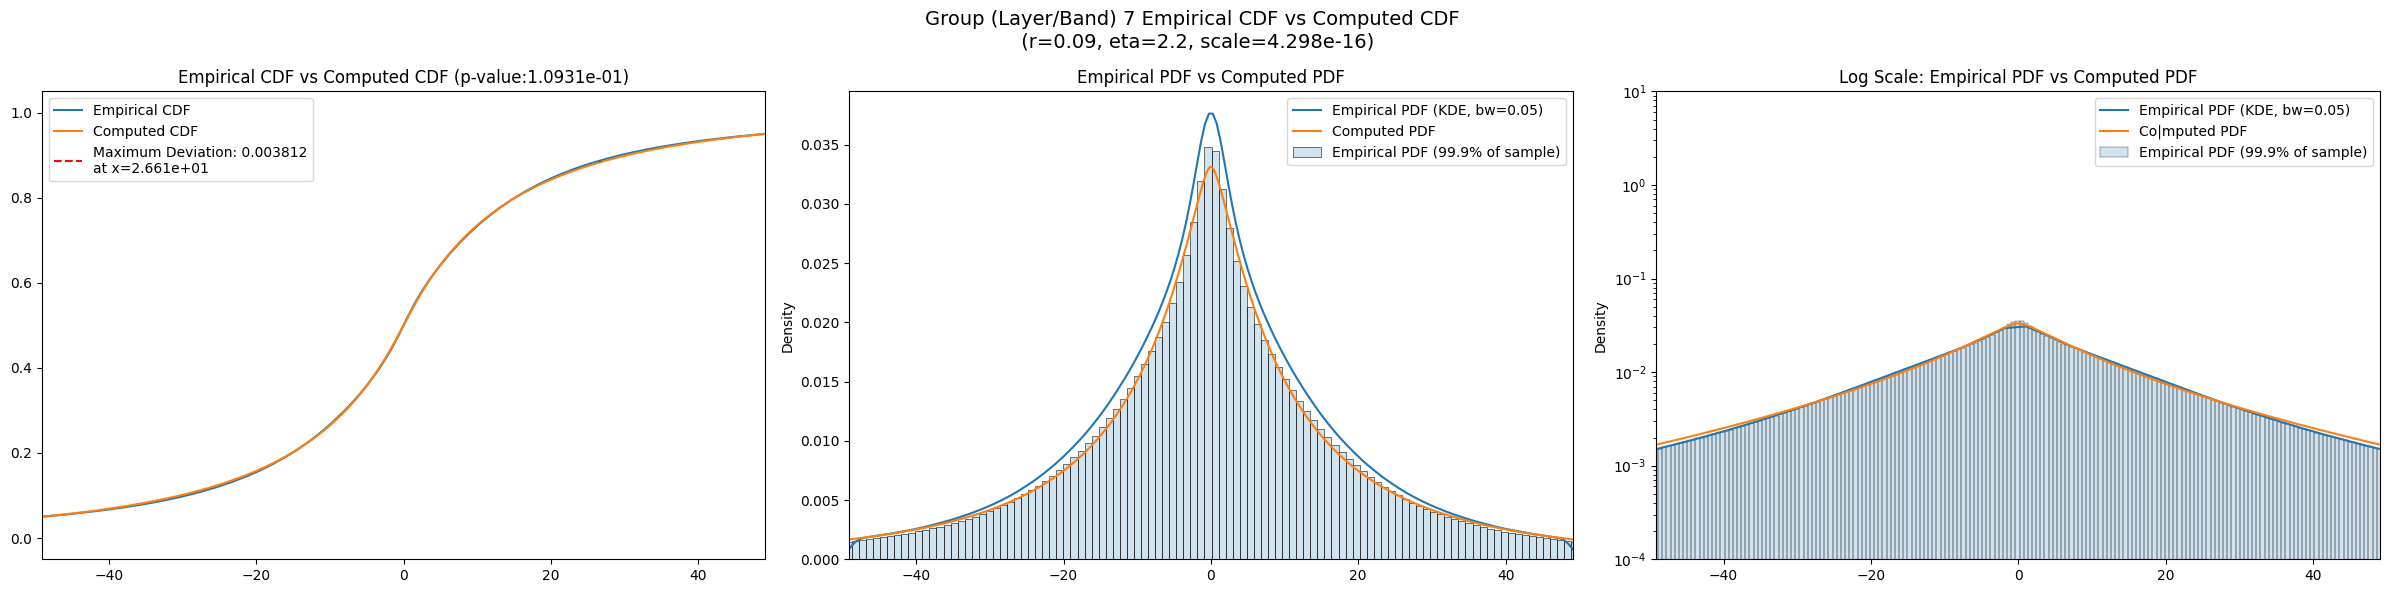

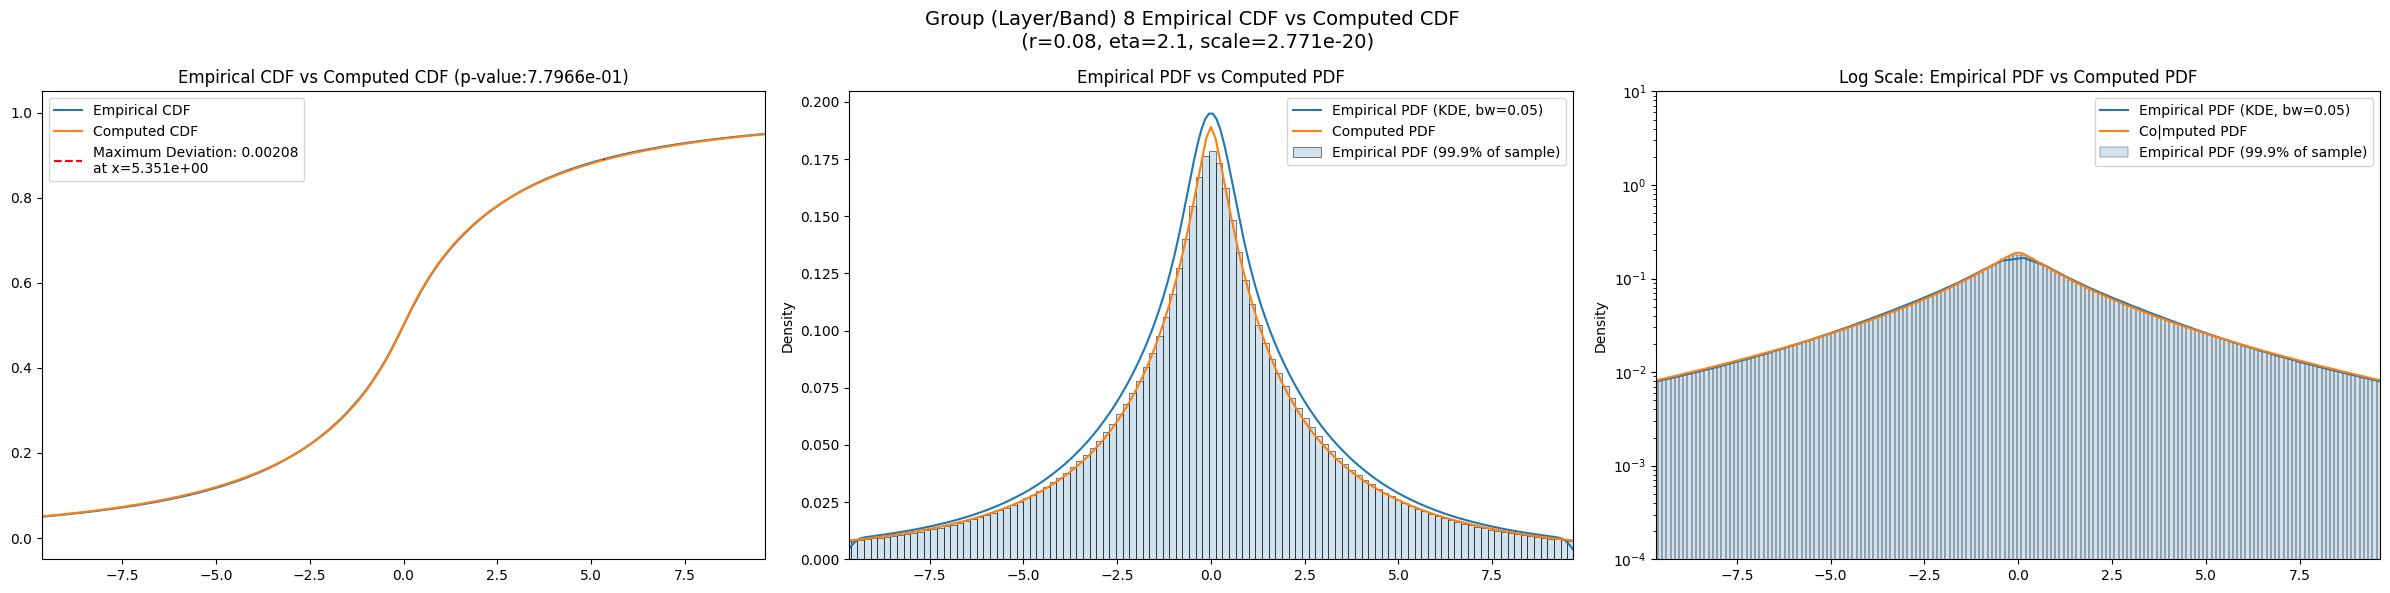

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                      
2               NaN            NaN           NaN         NaN         NaN   
3      1.177849e+06  996756.250000  1.369790e+06    0.133331   -0.296798   
4      5.544239e+05  530262.940000  5.787912e+05    0.887641    0.729112   
5      8.563575e+04   80896.880000  9.057298e+04    2.790587    2.209590   
6      1.720976e+04   15558.705000  1.896846e+04   12.881204   10.923777   
7      1.438634e+03    1291.273300  1.598209e+03   15.234228   12.320395   
8      5.583345e+01      46.389084  8.071121e+01  133.449080   13.199213   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2             NaN            0.0                  NaN        NaN          NaN   
3        0.629724          564.0             0.018039        0.6          5.3   
4        1.060642        22538.0             0.030388        0.5          0.0   
5        3.619065       296776.0             0.002095        0.7          0.0   
6       14.954548      2880648.0             0.005503        0.1          3.3   
7       18.880985     25362406.0             0.003644        0.1          1.8   
8      557.197800    213093688.0             0.002604        0.1          1.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...             NaN                   NaN                   NaN   
3      ...      1043.29000              0.019610          9.788850e-01   
4      ...       575.07200              0.055342          1.936030e-60   
5      ...       242.95600              0.025084         1.174980e-162   
6      ...        78.50520              0.034848          0.000000e+00   
7      ...        19.98610              0.045314          0.000000e+00   
8      ...         3.76004              0.049499          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2                NaN                  NaN                  NaN        NaN   
3          913.35800             0.026586         8.100050e-01  742.21100   
4          508.57400             0.029089         5.300980e-17  422.15400   
5          214.89500             0.006040         7.868580e-10  170.36800   
6           70.04490             0.013012         0.000000e+00   54.60520   
7           17.84340             0.020001         0.000000e+00   13.73800   
8            3.32729             0.023006         0.000000e+00    2.61078   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2                NaN            NaN                   NaN  
3           0.032906   5.631640e-01          9.914821e-01  
4           0.034493   9.851790e-24          1.947706e-17  
5           0.011226   6.473280e-33          2.170475e-01  
6           0.007492  6.944370e-141          3.058091e-68  
7           0.018020   0.000000e+00         3.403752e-272  
8           0.021670   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                      NaN                      NaN               NaN   
3                 0.018039                 0.056882          0.018037   
4                 0.030388                 0.009039          0.029468   
5                 0.002095                 0.002492          0.001933   
6                 0.005503                 0.000800          0.005206   
7                 0.003644                 0.000270          0.003512   
8                 0.002604                 0.000093          0.001932   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                       NaN                  NaN            NaN  
3                  0.019610             0.026586       0.032906  
4                  0.055342             0.029089       0.034493  
5                  0.025084             0.006040       0.011226  
6                  0.034848             0.013012       0.007492  
7                  0.045314             0.020001       0.018020  
8                  0.049499             0.023006       0.021670

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2                     NaN               NaN     NaN       NaN           NaN   
3            1.177849e+06          0.018037    0.64       4.9  3.091389e+04   
4            5.544239e+05          0.029468    0.55      -0.1  7.891671e+04   
5            8.563575e+04          0.001933    0.55       0.3  8.111061e+03   
6            1.393158e+04          0.005206    0.10       3.2  1.078205e-13   
7            1.300777e+03          0.003512    0.09       2.2  4.297988e-16   
8            5.583345e+01          0.001932    0.08       2.1  2.771022e-20   

       best_exclude_cutoff  
layer                       
2                      NaN  
3                      0.0  
4                      0.0  
5                      0.0  
6                    225.0  
7                     75.0  
8                      0.0

In [21]:
eng.quit()